In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from shapely.ops import nearest_points
from shapely.ops import unary_union
from shapely import speedups
from geopy.geocoders import Nominatim
from geopandas.tools import geocode
from geopy.extra.rate_limiter import RateLimiter

%matplotlib inline

## 1.

In [2]:
epsg=3067

In [19]:
# Test addresses
#orig_address_input = 'Radiokuja 6, 00240, Helsinki, Finland'
#dest_address_input = 'Väinö Auerin katu 13, 00560, Helsinki, Finland'

# Test addresses2
orig_address_input = 'Yliopistonkatu 3, 00100, Helsinki, Finland'
dest_address_input = 'Haartmaninkatu 8, 00290, Helsinki, Finland'

# Addresses with user input
#orig_address_input = str(input('Lähtöosoite')+', Helsinki, Finland')
#dest_address_input = str(input('Päämääräosoite')+', Helsinki, Finland')

# Geocode addresses
origin_point = geocode(orig_address_input, provider='nominatim', user_agent='autogis_EH', timeout=10)
dest_point = geocode(dest_address_input, provider='nominatim', user_agent='autogis_EH', timeout=10)

# Project to ETRS-TM35FIN
orig_point = origin_point.to_crs(epsg=epsg)
dest_point = dest_point.to_crs(epsg=epsg)

In [20]:
# Reading in the YKR grid
fp_grid = r'data/YKR/MetropAccess_YKR_grid_EurefFIN.shp'
grid = gpd.read_file(fp_grid)

# Checking projections
if grid.crs == orig_point.crs == dest_point.crs:
    print('data is correctly projected')
else:
    print('projections do not match')

data is correctly projected


In [21]:
# Defining centroids for the YKR grid

# Dataframe for centroids
grid_centroids = gpd.GeoDataFrame()

# Defining a centroid for every grid cell
grid_centroids['geometry'] = gpd.points_from_xy(grid.x, grid.y)

# Keeping the YKR_ID for data selection
grid_centroids['YKR_ID'] = grid['YKR_ID']

# Results
grid_centroids.head()

,geometry,YKR_ID
0,POINT (381875.000 6697880.000),5785640
1,POINT (382125.000 6697880.000),5785641
2,POINT (382375.000 6697880.000),5785642
3,POINT (382625.000 6697880.000),5785643
4,POINT (381125.000 6697630.000),5787544


In [22]:
# Function for getting the YKR_ID value of the nearest cell centroid
def get_nearest_values(row, other_gdf, point_column='geometry', value_column='geometry'):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf['geometry'].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf['geometry'] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [23]:
# Applying the function 

# Finding closest centroid to orig_point 
orig_point['YKR_ID'] = orig_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
)

# Finding closest centroid to dest_point
dest_point['YKR_ID'] = dest_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
)

# Assigning YKR_IDs to variables
orig_YKR = orig_point.loc[0, 'YKR_ID']
dest_YKR = dest_point.loc[0, 'YKR_ID']
print(dest_YKR, orig_YKR)

5960104 5975376


In [38]:
# Select apprpriate travel time data with dest_point's YKR_ID
fp_tt = r'data/traveltimes/travel_times_to_ '+str(dest_YKR)+'.txt'

# Read in data
tt_data = pd.read_csv(fp_tt, sep=';', na_values=['-1'])

# Merge travel time data to YKR grid and drop na values
tt_grid = grid.merge(tt_data, on=tt_data['from_id'])
tt_grid = tt_grid.dropna()

In [25]:
# Cells to gdf
orig_cell = gpd.GeoDataFrame()
dest_cell = gpd.GeoDataFrame()

orig_cell = grid.loc[grid['YKR_ID']==orig_YKR]
dest_cell = grid.loc[grid['YKR_ID']==dest_YKR]

<AxesSubplot:>

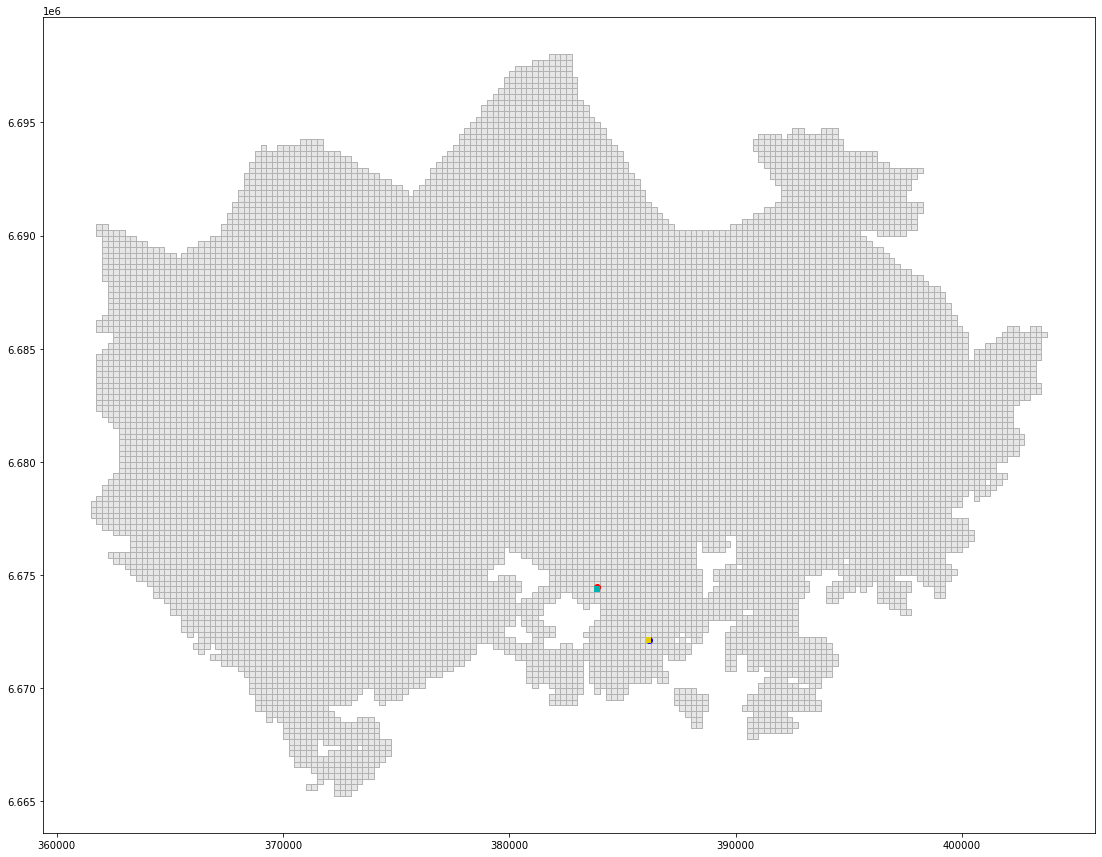

In [44]:
fig, ax = plt.subplots(figsize=(20,15))

grid.plot(ax=ax, facecolor=[0.9,0.9,0.9], edgecolor=[0.7,0.7,0.7])
orig_point.plot(ax=ax, color=[0,0,1])
dest_point.plot(ax=ax, color=[1,0,0])
orig_cell.plot(ax=ax, facecolor=[0.9,0.8,0])
dest_cell.plot(ax=ax, facecolor=[0,0.7,0.7])
#tt_grid.plot(ax=ax, column='pt_r_t', cmap='RdYlBu')
#grid_centroids.plot(ax=ax, color=[0,0,0], markersize=1)